<a href="https://colab.research.google.com/github/Samiul-25/Plant_Leaf_Disease_Detection/blob/main/Plant_Leaf_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import Kaggle

In [37]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


#API Command connected with kaggle dataset

In [38]:
! kaggle datasets download -d emmarex/plantdisease

plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)


#Unzip data

In [39]:
! unzip -q "plantdisease.zip"

replace PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#Set dataset path

In [40]:
datasets_dir = "PlantVillage"


#Variable

In [41]:
epochs = 32
IMG_SIZE = 128
BATCH_SIZE = 32

#Dataset Load

In [42]:
import tensorflow as tf
import numpy as np
tf.random.set_seed(42)



train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="training"

).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="validation"

)
class_names = test_dataset.class_names
test_data = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
class_names


Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.


['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

#Plot Image

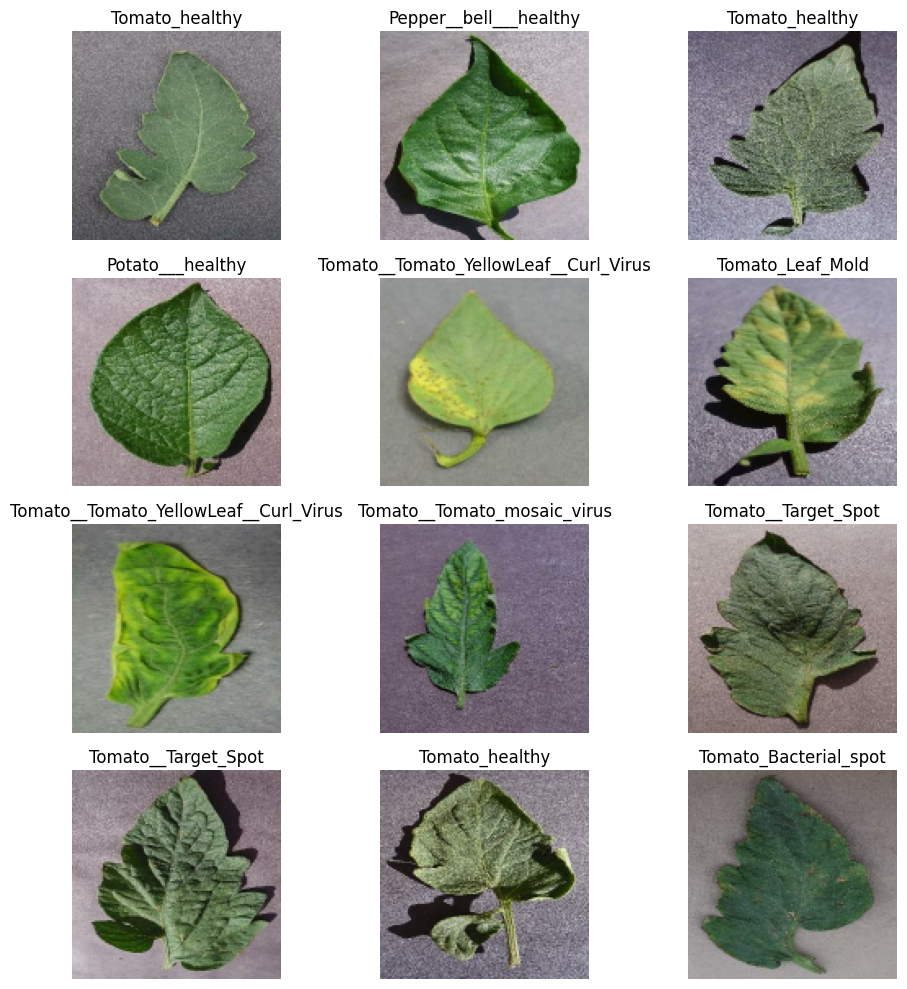

In [43]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
plt.tight_layout()
plt.show()

#Data Augmentation

In [44]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
], name ="data_augmentation")

#Augmented Image View

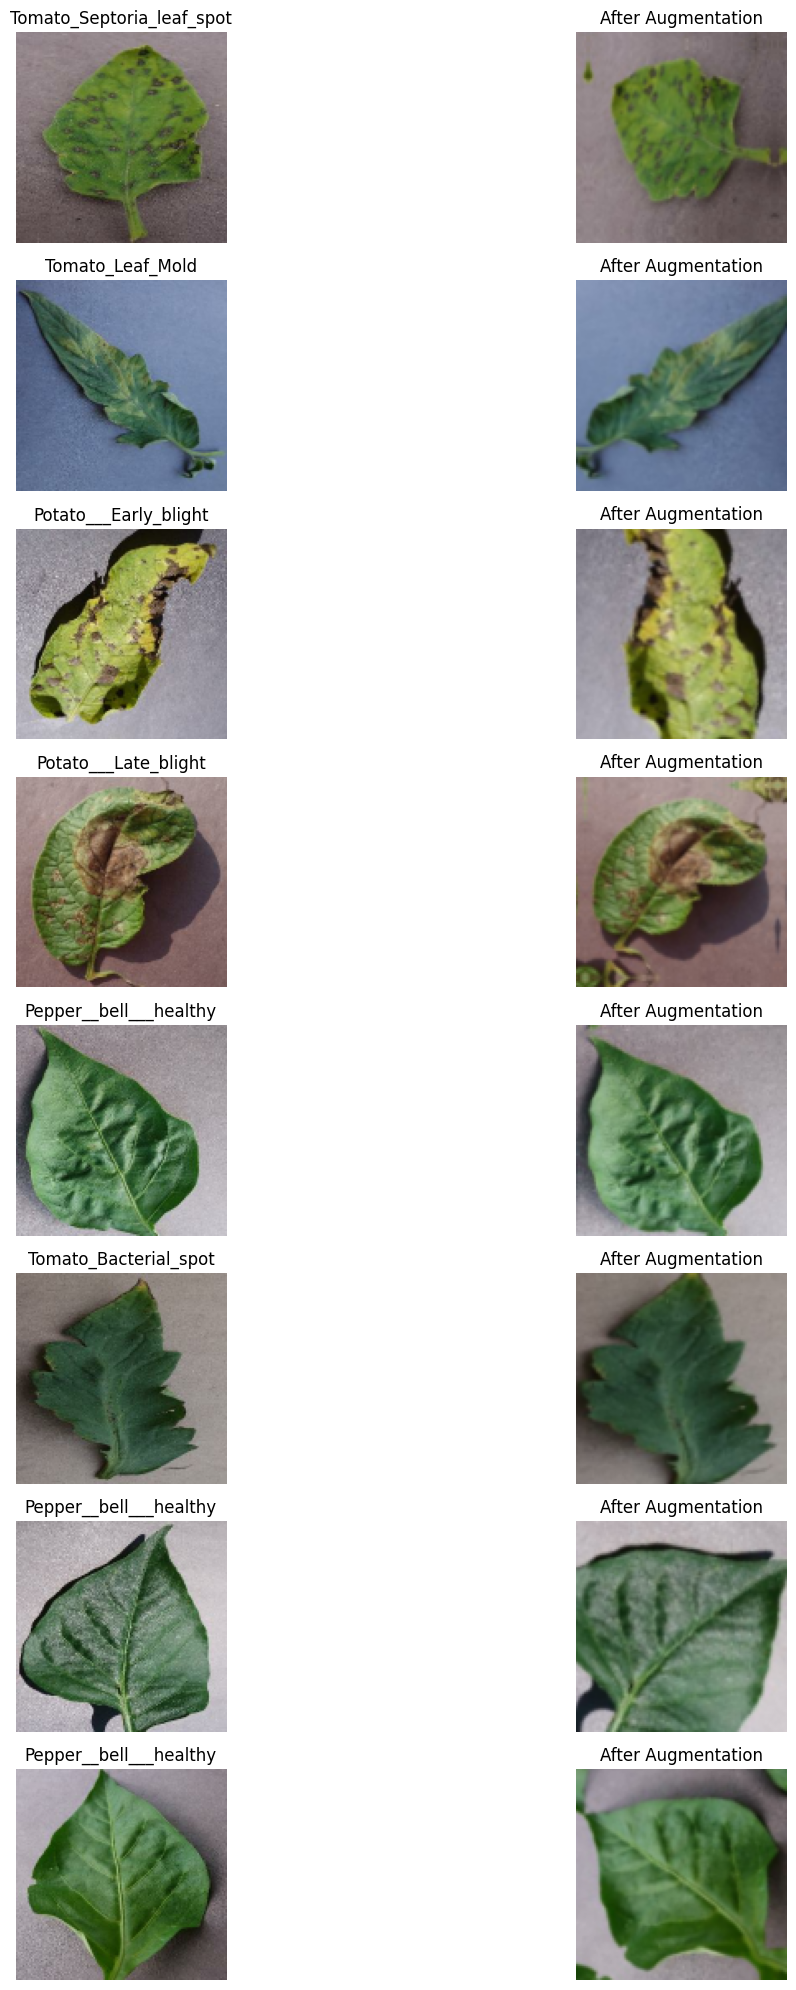

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))  # Adjust the figure size as needed

# Assuming train_data is your dataset iterator
for image_batch, label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = min(len(image_batch), 8)  # Ensure we don't exceed 8 images
    for i in range(image_plt_len):
        # Plot original images
        plt.subplot(image_plt_len, 2, 2 * i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

        # Plot augmented images
        plt.subplot(image_plt_len, 2, 2 * i + 2)
        img = augmented_image_batch[i].numpy().astype("uint32")
        plt.imshow(img)
        plt.title("After Augmentation")
        plt.axis("off")

plt.tight_layout()
plt.show()


#Building Model

In [47]:
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.models import Sequential
model = Sequential()

In [48]:
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[128,128,3]))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Dropout(0.25))   #To avoid Overfitting

model.add(Flatten())
model.add(Dense(units=1500,activation='relu'))

model.add(Dropout(0.4))
model.add(Dense(units=15,activation='softmax'))

# Test the model

In [49]:
model.compile(
    loss='categorical_crossentropy',  # Example loss function for multi-class classification
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Example optimizer (you can choose others like SGD, RMSprop, etc.)
    metrics=['accuracy']               # Example metric to monitor during training
)

In [50]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_38 (Conv2D)          (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 63, 63, 64)        18496     
                                                                 
 conv2d_40 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                

#model Training

In [51]:
epochs = 10
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs
)

Epoch 1/10
516/516 [==============================] - 2476s 5s/step - loss: 1.5470 - accuracy: 0.5015 - val_loss: 0.7494 - val_accuracy: 0.7570
Epoch 2/10
516/516 [==============================] - 2408s 5s/step - loss: 0.6728 - accuracy: 0.7705 - val_loss: 0.5429 - val_accuracy: 0.8137
Epoch 3/10
516/516 [==============================] - 2498s 5s/step - loss: 0.4658 - accuracy: 0.8419 - val_loss: 0.3192 - val_accuracy: 0.8953
Epoch 4/10
516/516 [==============================] - 2415s 5s/step - loss: 0.3252 - accuracy: 0.8894 - val_loss: 0.3801 - val_accuracy: 0.8709
Epoch 5/10
516/516 [==============================] - 2454s 5s/step - loss: 0.2382 - accuracy: 0.9190 - val_loss: 0.2998 - val_accuracy: 0.8975
Epoch 6/10
516/516 [==============================] - 2386s 5s/step - loss: 0.1738 - accuracy: 0.9405 - val_loss: 0.2419 - val_accuracy: 0.9208
Epoch 7/10
516/516 [==============================] - 2474s 5s/step - loss: 0.1481 - accuracy: 0.9494 - val_loss: 0.2099 - val_accuracy:

#Evaluation model

In [6]:
train_loss,train_acc=model.evaluate(test_data)

NameError: name 'model' is not defined

In [5]:
print(train_loss,train_acc)

NameError: name 'train_loss' is not defined